## 세팅 시작

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna
import gc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

c:\Users\CY2\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 최적화 관련 코드

In [2]:
# 메모리를 32비트로 변환
def optimize_memory(df):
    for col in df.select_dtypes(include=['number']).columns:
        # 정수형은 가능한 가장 작은 타입으로 (int8, int16 등)
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # 실수형은 float32로
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

## 파일을 불러오고, 폴더별로 합치기

In [3]:
# 함수로 만들어서 넣어버리자 그냥
# 각 폴더명 딕셔너리
HOME = os.getcwd()
def makeFileList(option = "train"):
    folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

    # 현재 디렉터리
    HOME = os.getcwd()

    # 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
    folder_list = []
    for value in folder_name.values():
        folder_list.append(os.path.join(HOME, "data", option, value))
    print(len(folder_list))

    # 폴더 내 파일 리스트 읽어오기
    fileNameList = {}
    for i in range(len(folder_list)):
        fileNameList[i+1] = os.listdir(folder_list[i])
    print(fileNameList)

    # 파일 경로 리스트 생성
    filePathList = {}
    temp = []
    for i in range(len(folder_list)):
        for j in range(len(fileNameList[i+1])):
            temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
        filePathList[i+1] = temp
        temp = []

    return filePathList

In [4]:
# 240만개의 파일을 이어 붙이기
# 각 폴더에 들어있는 파일들 중 같은 달의 열을 모두 합침
def load_cat(i, filePathList):
    print("현재 진행 상황 : {}".format(i))
    df = optimize_memory(pd.read_parquet(filePathList[i][0]))
    for j in range(1,6):
        print("Debugging1")
        df = pd.concat([df, optimize_memory(pd.read_parquet(filePathList[i][j]))])
    return df

# 공통된 쓸모없는 column 제거 함수=
def drop_useless(df):
    df = df.drop(columns = ["기준년월", "ID"])
    return df
# target인 Segment가 없을시 Segment 추가
def add_target(df, filePathList):# target이 존재하지 않는 df, target명(문자열)
    temp_df = pd.read_parquet(filePathList[1][0])
    for i in range(1, 6):
        temp_df = pd.concat([temp_df, pd.read_parquet(filePathList[1][i])])
    df = pd.merge(temp_df[["기준년월", "ID", "Segment"]], df, on = ["기준년월","ID"],how = "left")
    return df

# 파일을 불러오는 함수
def make_df(i, option = False):# option이 True면 Test데이터도 불러오게 하자.

    # train 데이터 불러오기
    train = makeFileList()
    test = makeFileList(option = "test")
    train = load_cat(i, train)

    # test 데이터 불러오기
    if option == "all":
        train = pd.DataFrame()
        for i in range(1, 9):
            train = pd.concat([train, drop_useless(load_cat(i, makeFileList()))], axis = 1)    
        test = pd.DataFrame()
        for i in range(1, 9):
            test = pd.concat([test, drop_useless(load_cat(i, makeFileList(option = "test")))], axis = 1)
    elif option:
        train = drop_useless(add_target(train, makeFileList()))
        test = drop_useless(load_cat(i, test))

    
    # option 이 True 라면 concat해서 붙여넣기 : if로 하지 않으면 앞에 test를 선언했기 때문에 오류 날 것
    if option:
        print(train.shape)
        print(test.shape)

        result = pd.concat([train, test], ignore_index=True)
        print(result.shape)
        return result
    else :
        print(train.shape)
        if (i > 1) & (i <= 6): train = add_target(train, makeFileList())
        elif i == 1: return drop_useless(train)
        else: print("숫자가 아니거나 할당 없는 카테고리입니다.")
        return drop_useless(train)
    # i 가 1보다 크고 1보다 작을때 사용



# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

## 사용하면 되는 함수
- make_df(i, option = False)
    - 데이터를 불러와 데이터 프레임을 만들어 내는 함수
    - i는 폴더를 불러오기 위한 변수
    - 기본적으로 option = False
    - option에 아무 값이나 넣으면 True가 되고, 그러면 해당하는 Test값이 들어간다.
    - option에 "all"이 들어가면 모든 데이터를 합쳐서 만들어줌

In [5]:
# 만들어둔 함수를 통해, 불러오고 싶은 폴더를 입력하면 데이터를 한번에 불러와준다.
df = make_df(2, option = "all")

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

## 전처리 및 피쳐 엔지니어링

### 전처리

### 피쳐엔지니어링

##### 한도소진율

✅ ID 컬럼 확보 완료! 집계 및 시각화를 진행합니다.


C:\Users\CY2\AppData\Local\Temp\ipykernel_55400\474991373.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=data,


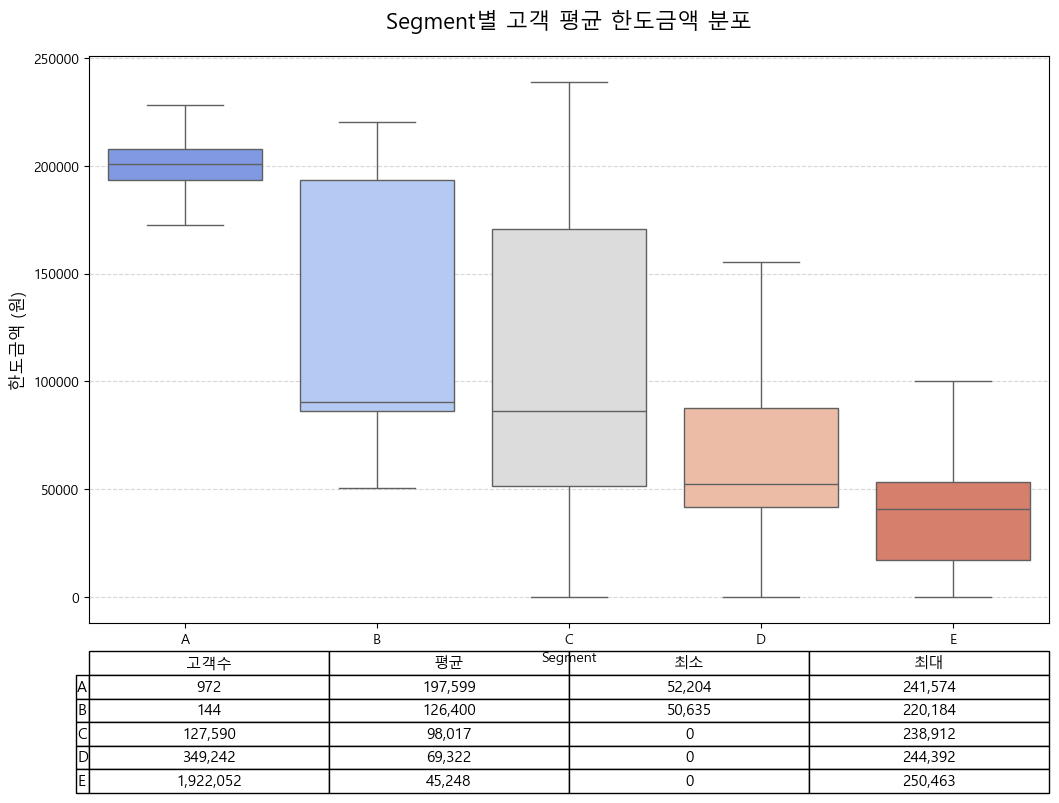

C:\Users\CY2\AppData\Local\Temp\ipykernel_55400\474991373.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=data,


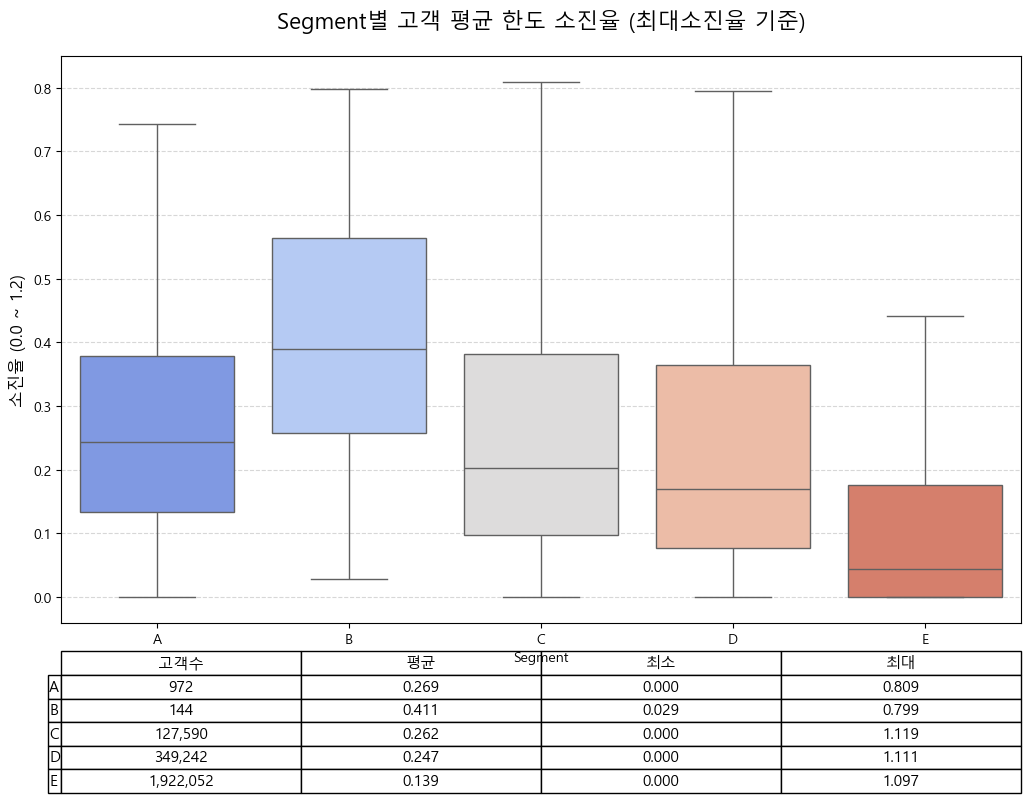

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# ---------------------------------------------------------
# 1. 폰트 설정
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. [오류 해결] ID 컬럼 복구 (Index -> Column)
# ---------------------------------------------------------
# merged_df가 정의되어 있다고 가정합니다. (이전 셀 실행 결과)

# 'ID'가 컬럼에 없고, 혹시 인덱스 이름이 'ID'라면 리셋
if 'ID' not in merged_df.columns:
    print("⚠️ 'ID' 컬럼이 보이지 않아 인덱스 초기화를 시도합니다...")
    merged_df = merged_df.reset_index()

# 리셋 후에도 'ID'가 없는 경우 (인덱스 이름이 다른 경우 등)
if 'ID' not in merged_df.columns:
    # 혹시 컬럼명이 'index'로 되어있거나 대소문자가 다른지 확인
    print(f"❌ 여전히 'ID' 컬럼이 없습니다. 현재 컬럼 목록: {list(merged_df.columns)}")
    # 만약 'index'라는 컬럼이 생겼고 그게 ID라면 이름 변경
    if 'index' in merged_df.columns:
        print("ℹ️ 'index' 컬럼을 'ID'로 변경합니다.")
        merged_df.rename(columns={'index': 'ID'}, inplace=True)

# ---------------------------------------------------------
# 3. 데이터 집계 및 시각화 재시도
# ---------------------------------------------------------
if 'ID' in merged_df.columns and 'Segment' in merged_df.columns:
    print("✅ ID 컬럼 확보 완료! 집계 및 시각화를 진행합니다.")

    # (1) ID별 평균 계산
    user_stats_df = merged_df.groupby(['ID', 'Segment'], observed=True).agg({
        '카드이용한도금액': 'mean',
        '잔액_신판최대한도소진율_r3m': 'mean'
    }).reset_index()

    user_stats_df.rename(columns={
        '카드이용한도금액': '평균한도금액',
        '잔액_신판최대한도소진율_r3m': '평균소진율'
    }, inplace=True)

    # (2) 시각화 함수 정의
    def plot_segment_analysis(data, x_col, y_col, title, y_label):
        # 순서 정렬
        if data[x_col].dtype.name != 'category':
            data[x_col] = pd.Categorical(data[x_col], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)
        
        # 통계값 계산
        stats = data.groupby(x_col)[y_col].agg(['count', 'mean', 'min', 'max'])
        
        # 그래프
        fig, ax = plt.subplots(figsize=(12, 9))
        sns.boxplot(x=x_col, y=y_col, data=data, 
                    order=['A', 'B', 'C', 'D', 'E'], 
                    palette='coolwarm', showfliers=False, ax=ax)
        
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # 표 추가
        cell_text = []
        for row in stats.values:
            if '소진율' in title:
                formatted_row = [f"{int(row[0]):,}", f"{row[1]:.3f}", f"{row[2]:.3f}", f"{row[3]:.3f}"]
            else:
                formatted_row = [f"{x:,.0f}" if i==0 else f"{x:,.0f}" for i, x in enumerate(row)]
            cell_text.append(formatted_row)
            
        the_table = plt.table(cellText=cell_text,
                              rowLabels=stats.index,
                              colLabels=['고객수', '평균', '최소', '최대'],
                              loc='bottom', cellLoc='center',
                              bbox=[0.0, -0.3, 1.0, 0.25])
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(11)
        the_table.scale(1, 1.5)

        plt.subplots_adjust(left=0.1, bottom=0.25)
        plt.show()

    # (3) 실행
    # 한도금액
    plot_segment_analysis(user_stats_df, 'Segment', '평균한도금액', 
                          'Segment별 고객 평균 한도금액 분포', '한도금액 (원)')

    # 소진율 (이상치 Cap)
    user_stats_df['시각화용_소진율'] = user_stats_df['평균소진율'].clip(0, 1.2)
    plot_segment_analysis(user_stats_df, 'Segment', '시각화용_소진율', 
                          'Segment별 고객 평균 한도 소진율 (최대소진율 기준)', '소진율 (0.0 ~ 1.2)')

else:
    print("❌ 오류: 'ID' 또는 'Segment' 컬럼을 찾을 수 없습니다.")
    print(f"현재 컬럼 목록: {list(merged_df.columns)}")

In [42]:
import numpy as np

# ---------------------------------------------------------
# A/B 구분 필살기 파생변수 생성
# ---------------------------------------------------------

# 1. [1차 필터] 우량 고객 후보군 (Premium Candidate)
# 설명: "한도가 5만 원도 안 되면 절대 A, B가 아니다"라는 규칙을 0/1로 박아줍니다.
# 효과: C, D, E 하위 그룹을 1차적으로 걸러냅니다.
threshold_limit = 50000
user_stats_df['우량후보_여부'] = (user_stats_df['평균한도금액'] >= threshold_limit).astype(int)

# 2. [A/B 분리기] 실질 여유 한도 (Real Spare Limit) ★가장 강력함★
# 공식: 평균한도 * (1 - 소진율)
# 설명: "지금 당장 융통할 수 있는 현금 여력"이 얼마인가?
#   - A (부자 & 절약): 한도(大) * 여유(大) = 결과값 [초대형] (예: 13만원)
#   - B (부자 & 낭비): 한도(中) * 여유(小) = 결과값 [중소형] (예: 6만원)
#   - C/D/E: 한도가 작아서 결과값 [소형/영(0)]
user_stats_df['실질여유한도'] = user_stats_df['평균한도금액'] * (1 - user_stats_df['평균소진율'])

# 3. [공격성 지표] 한도 대비 소비성향 (Limit Aggressiveness)
# 공식: 평균소진율 / log(평균한도)
# 설명: 한도가 큰데 소진율까지 높으면(B) 점수가 확 튀게 만듭니다.
#   - A: 분자(소진율)가 낮아서 점수가 낮음 (안정적)
#   - B: 분자(소진율)가 높고 분모(한도)는 A보다 작아서 점수가 높음 (공격적)
# (log를 씌운 이유는 한도 금액의 단위가 너무 커서 소진율이 묻히는 것을 방지하기 위함입니다)
user_stats_df['한도대비_소비성향'] = user_stats_df['평균소진율'] / np.log1p(user_stats_df['평균한도금액'])

# ---------------------------------------------------------
# 생성된 변수 검증 (A와 B가 잘 벌어졌는지 눈으로 확인)
# ---------------------------------------------------------
print("변수 생성 완료! 등급별 평균값 비교:")
check_cols = ['평균한도금액', '평균소진율', '우량후보_여부', '실질여유한도', '한도대비_소비성향']
display(user_stats_df.groupby('Segment')[check_cols].mean().round(4))

변수 생성 완료! 등급별 평균값 비교:


,평균한도금액,평균소진율,우량후보_여부,실질여유한도,한도대비_소비성향
Segment,,,,,
A,197598.8323,0.2694,1.0000,145085.6767,0.0221
B,126400.1250,0.4108,1.0000,77921.2250,0.0355
C,98017.1009,0.2616,0.7928,75935.8600,inf
D,69321.6125,0.2468,0.5877,56116.8822,inf
E,45248.4548,0.1394,0.3458,40933.9013,inf


In [44]:
import numpy as np

# -----------------------------------------------------------------------------
# [Feature Engineering] A/B 등급 정밀 분류를 위한 파생변수 3종 추가
# -----------------------------------------------------------------------------

# 1. 우량후보 여부: 한도 5만 원 미만(C,D,E)은 0, 이상은 1 (1차 필터)
df['우량후보_여부'] = (df['카드이용한도금액'] >= 50000).astype(int)

# 2. 실질 여유 한도: 한도는 크고 소진율은 낮은 '찐부자(A)'를 가려내는 변수
df['실질여유한도'] = df['카드이용한도금액'] * (1 - df['잔액_신판최대한도소진율_r3m'])

# 3. 한도 대비 소비성향: A(안정)와 B(공격적)를 가르고, CDE(한도부족)를 99로 밀어내는 변수
df['한도대비_소비성향'] = df['잔액_신판최대한도소진율_r3m'] / np.log1p(df['카드이용한도금액'])

# (중요) 한도가 0에 가까워 무한대(inf)가 나오면 하위 등급 값(99)으로 처리
df['한도대비_소비성향'] = df['한도대비_소비성향'].replace([np.inf, -np.inf], 99).fillna(99)

##### 증감율

### 표준화

## 모델 학습을 위해 분할 시작

- 윗단계를 실행했었다면 세팅만 돌리고 아랫단계만 돌려도 된다.

In [7]:
train = optimize_memory(pd.read_parquet(os.path.join(HOME, "train_data.parquet")))


In [8]:
# train 데이터 준비
X_train = train.drop('Segment', axis=1)
y_train = train['Segment']

# 최적화를 위해 필요한 코드. 필요할 경우, 아래 내용을 주석처리할 것
del train
gc.collect()

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [9]:
X_train

,남녀구분코드,연령,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,입회경과개월수_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
963349,2,50대,1,1,0,1,1,1,20130301,67,...,0.999998,0.596566,0.000000,0.999998,0.928230,0.063125,0.412493,0.0,3.248626,0.000000
1972916,2,40대,1,1,1,1,1,1,20180601,6,...,0.999998,0.903477,0.999998,0.999998,0.999998,-0.032744,0.107426,0.0,0.000000,0.000000
1635048,2,30대,1,1,1,1,1,1,20170801,16,...,0.999998,0.999998,0.999998,0.999998,0.999998,-0.063179,-0.021823,0.0,0.000000,0.000000
1630396,1,40대,1,1,1,1,3,3,20000701,221,...,0.999998,0.999998,0.999998,0.999998,0.999998,-0.163887,-0.225702,0.0,1.688003,3.562608
1298253,2,30대,1,1,0,1,1,0,20160101,34,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586741,1,50대,1,1,1,1,1,1,20090601,113,...,1.014374,0.999998,0.999998,0.999998,0.999998,-0.062256,-0.057514,0.0,0.000000,0.000000
560151,2,40대,1,1,1,1,2,2,20161101,22,...,0.953437,0.999998,0.999998,0.999998,0.999998,0.083471,0.074486,0.0,0.000000,0.000000
525760,1,30대,1,1,1,1,2,2,20130801,61,...,0.999998,0.999998,0.999998,0.999998,0.999998,-0.204766,-0.279814,0.0,4.751161,5.927907
1792077,1,50대,1,1,1,1,1,1,20180601,6,...,0.999998,0.999998,0.999998,0.999998,0.999998,-0.045391,-0.140159,0.0,10.100915,13.159251


In [12]:
# 글로벌 변수로 best model 저장
best_model = None

# CatBoost 하이퍼파라미터 튜닝
def objective_cat(trial):
    global best_model
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric' : "MultiClass",
        'verbose': 0,
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    
    # Best model 저장
    if best_model is None or score > best_f1_score:
        best_model = model
        best_f1_score = score
    
    return score

best_f1_score = 0
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=10)
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost score:", study_cat.best_value)

[I 2026-02-10 09:02:55,121] A new study created in memory with name: no-name-2543c582-98cd-491a-803e-3890d2d69f26
[W 2026-02-10 09:02:55,375] Trial 0 failed with parameters: {'iterations': 103, 'depth': 4, 'learning_rate': 0.0473761534213084, 'l2_leaf_reg': 9.194877558099247, 'border_count': 202} because of the following error: CatBoostError('Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="50대": Cannot convert \'50대\' to float').
Traceback (most recent call last):
  File "_catboost.pyx", line 2534, in _catboost.get_float_feature
  File "_catboost.pyx", line 1228, in _catboost._FloatOrNan
  File "_catboost.pyx", line 1023, in _catboost._FloatOrNanFromString
TypeError: Cannot convert '50대' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\CY2\miniconda3\envs\DS\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="50대": Cannot convert '50대' to float

In [ ]:
# Best 모델에서 Feature Importance 시각화 (재학습 불필요 - 이미 위에서 저장됨)
# Feature Importance 추출
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

# DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Seaborn으로 시각화
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('CatBoost Feature Importance (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Top 20 Feature 시각화 (Feature가 많을 경우)
if len(importance_df) > 20:
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), y='Feature', x='Importance', palette='rocket')
    plt.title('CatBoost Top 20 Feature Importance (Best Model)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# 상위 10개 Feature 출력
print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10))